In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Loading dataset & reviewing data 

In [2]:
df=pd.read_csv('Covid_19_train.csv')
df

,Time,Daily_cases
0,2020-02-29,1.0
1,2020-03-01,9.0
2,2020-03-02,3.0
3,2020-03-03,9.0
4,2020-03-04,16.0
...,...,...
200,2020-09-16,1266.0
201,2020-09-17,1475.0
202,2020-09-18,1540.0
203,2020-09-19,1582.0


In [3]:
df["Time"]=pd.to_datetime(df['Time'])
df.set_index('Time',inplace=True)
df

,Daily_cases
Time,
2020-02-29,1.0
2020-03-01,9.0
2020-03-02,3.0
2020-03-03,9.0
2020-03-04,16.0
...,...
2020-09-16,1266.0
2020-09-17,1475.0
2020-09-18,1540.0


In [4]:
#checking possible null value in train set
train=df['Daily_cases']
train.isnull().sum()

0

In [5]:
#checking data type
print(df.dtypes)

Daily_cases    float64
dtype: object


# EDA

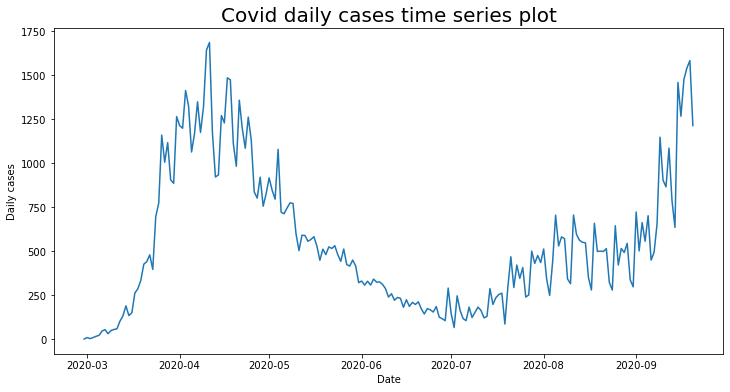

<Figure size 432x288 with 0 Axes>

In [6]:
#plotting time series 
plt.figure(figsize=(12,6))
plt.plot(train)
plt.title('Covid daily cases time series plot',fontsize=20)
plt.xlabel('Date')
plt.ylabel('Daily cases')
plt.show()
plt.savefig('Covid daily cases time series plot')

## Exploring moving average

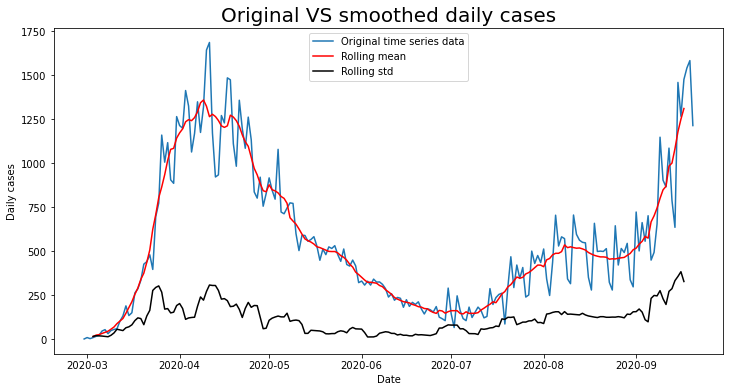

<Figure size 432x288 with 0 Axes>

In [7]:
#exploring and smoothing seasonality by CMA
rolling_data=train.rolling(7, center=True)
#explored and identified possible seasonality is 7 days
rolling_mean=rolling_data.mean()
rolling_std=rolling_data.std()

#plot original data and smoothed data
plt.figure(figsize=(12,6))
plt.plot(train,label='Original time series data')
plt.plot(rolling_mean,'red',label='Rolling mean')
plt.plot(rolling_std,'black',label='Rolling std')
plt.title('Original VS smoothed daily cases',fontsize=20)
plt.xlabel('Date')
plt.ylabel('Daily cases')
plt.legend()
plt.show()
plt.savefig('Original VS smoothed daily cases')

## Decomposing

### Additive Decomposition

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from matplotlib.pylab import rcParams

In [9]:
add_dec = seasonal_decompose(df['Daily_cases'], model='additive', extrapolate_trend='freq')

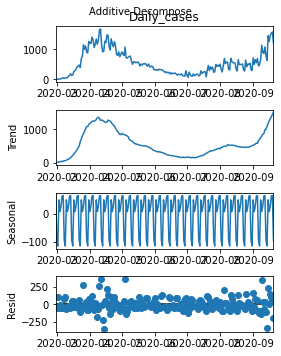

<Figure size 288x360 with 0 Axes>

In [10]:
#plotting additive decompose
plt.rcParams.update({'figure.figsize': (4,5)})
add_dec.plot().suptitle('Additive Decompose',fontsize=10)
plt.show()
plt.rc('xtick',labelsize=10) 
plt.rc('ytick',labelsize=10)
plt.savefig('Additive Decompose')

### Multiplicative Decomposition 

In [11]:
mul_dec = seasonal_decompose(df['Daily_cases'], model='multiplicative', extrapolate_trend='freq')

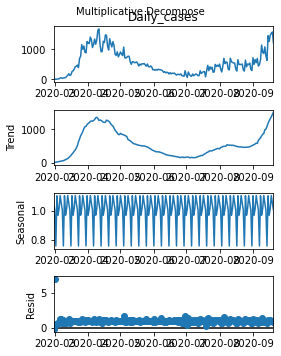

<Figure size 288x360 with 0 Axes>

In [12]:
plt.rcParams.update({'figure.figsize': (4,5)})
mul_dec.plot().suptitle('Multiplicative Decompose',fontsize=10)
plt.show()
plt.savefig('Multiplicative Decompose')

## ACF & PACF

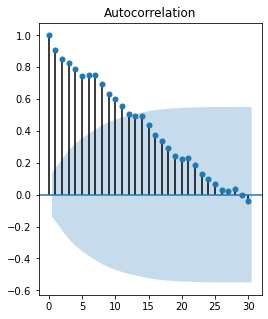

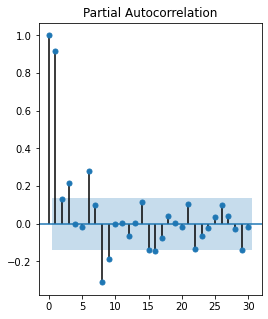

<Figure size 288x360 with 0 Axes>

In [13]:
import statsmodels.api as smt
smt.graphics.tsa.plot_acf(train,lags=30, alpha=0.05)
smt.graphics.tsa.plot_pacf(train,lags=30,alpha=0.05)
plt.show()
plt.savefig('Original ACF & PACF')

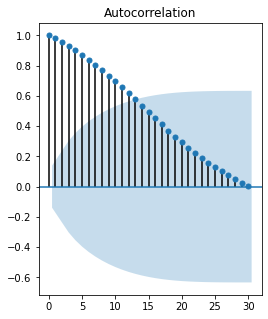

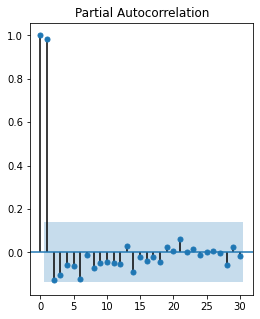

<Figure size 288x360 with 0 Axes>

In [14]:
#plotting ACF and PACF for rolling mean data
smt.graphics.tsa.plot_acf(rolling_mean.dropna(),lags=30,alpha=0.05)
#droping the null value produced by applying rolling mean
smt.graphics.tsa.plot_pacf(rolling_mean.dropna(),lags=30,alpha=0.05)
plt.show()
plt.savefig('Rolling mean ACF & PACF')

# Models

# 1. Decomposition model

In [15]:
#1.load the data

df = pd.read_csv("Covid_19_train.csv")
df['Time'] =pd.to_datetime(df['Time'])
df.set_index('Time',inplace = True)
df.head()

,Daily_cases
Time,
2020-02-29,1.0
2020-03-01,9.0
2020-03-02,3.0
2020-03-03,9.0
2020-03-04,16.0


In [16]:
ts = df["Daily_cases"]
ts.isnull().sum()

0

In [17]:
#2.EDA"Time Series Plot"
#smoothing and check the trend
#ACF and PACF
# 4.train-test split
ts.shape

(205,)

In [18]:
# Split the train, test set
train_s = ts[:-16]
test_s =ts[-16:]

# Define the mse
def mse(y_pred, y_true):
    return np.mean(np.power(y_pred - y_true,2))

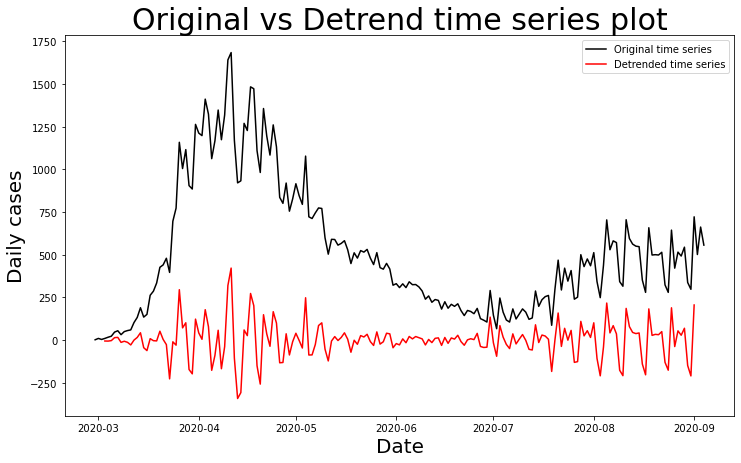

In [19]:
#5.Models Decomposition method
#step1:detrend using cma to find the trend

Trend = train_s.rolling(7, center = True).mean()
Detrend_ts = train_s - Trend

plt.figure(figsize =(12,7))
plt.plot(train_s,'black', label="Original time series")
plt.plot(Detrend_ts,'red', label="Detrended time series")
plt.title("Original vs Detrend time series plot",fontsize=30)
plt.xlabel('Date',fontsize=20)
plt.ylabel('Daily cases',fontsize=20)
plt.legend()
plt.savefig("Original vs Detrend time series plot")

In [20]:
Detrend_ts

Time
2020-02-29           NaN
2020-03-01           NaN
2020-03-02           NaN
2020-03-03     -6.142857
2020-03-04     -6.714286
                 ...    
2020-08-31   -210.857143
2020-09-01    205.000000
2020-09-02           NaN
2020-09-03           NaN
2020-09-04           NaN
Name: Daily_cases, Length: 189, dtype: float64

In [21]:
#step 2.Find Seasonal Index
#Fill nan with 0
ts_res_zeros = np.nan_to_num(Detrend_ts)
ts_res_zeros.shape

(189,)

In [22]:
#reshape and calculate column average
S_weekly = np.reshape(ts_res_zeros,(27,7))
S_weekly_avg = np.mean(S_weekly[1:-1,], axis = 0)
S_weekly_avg

array([ 59.        , -78.35428571, -98.13142857,  40.84      ,
        -4.96      ,  17.97142857,  65.91428571])

In [23]:
#normalize the seasonal index
mean_allweek = S_weekly_avg.mean()
S_weekly_avg_normed = S_weekly_avg - mean_allweek

In [24]:
S_weekly_avg_normed

array([ 58.67428571, -78.68      , -98.45714286,  40.51428571,
        -5.28571429,  17.64571429,  65.58857143])

In [25]:
#step3 Get seasonal adjusted series
np.tile(S_weekly_avg_normed, 27)

array([ 58.67428571, -78.68      , -98.45714286,  40.51428571,
        -5.28571429,  17.64571429,  65.58857143,  58.67428571,
       -78.68      , -98.45714286,  40.51428571,  -5.28571429,
        17.64571429,  65.58857143,  58.67428571, -78.68      ,
       -98.45714286,  40.51428571,  -5.28571429,  17.64571429,
        65.58857143,  58.67428571, -78.68      , -98.45714286,
        40.51428571,  -5.28571429,  17.64571429,  65.58857143,
        58.67428571, -78.68      , -98.45714286,  40.51428571,
        -5.28571429,  17.64571429,  65.58857143,  58.67428571,
       -78.68      , -98.45714286,  40.51428571,  -5.28571429,
        17.64571429,  65.58857143,  58.67428571, -78.68      ,
       -98.45714286,  40.51428571,  -5.28571429,  17.64571429,
        65.58857143,  58.67428571, -78.68      , -98.45714286,
        40.51428571,  -5.28571429,  17.64571429,  65.58857143,
        58.67428571, -78.68      , -98.45714286,  40.51428571,
        -5.28571429,  17.64571429,  65.58857143,  58.67

In [26]:
np.tile(S_weekly_avg_normed, 27)
S_tiled_avg = np.tile(S_weekly_avg_normed, 27)
seasonally_adjusted =train_s-S_tiled_avg

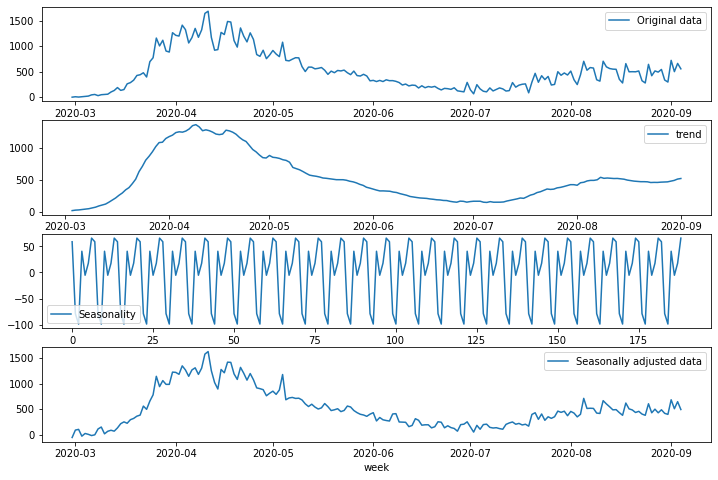

In [27]:
fig, ax = plt.subplots(4,1,figsize =(12,8))
ax[0].plot(train_s)
ax[1].plot(Trend)
ax[2].plot(S_tiled_avg)
ax[3].plot(seasonally_adjusted)

ax[0].legend(['Original data'],loc=0)
ax[1].legend(['trend'],loc=0)
ax[2].legend(['Seasonality'],loc=0)
ax[3].legend(['Seasonally adjusted data'],loc=0)
plt.xlabel('week')
plt.savefig("Seasonally adjusted")

In [28]:
# Step 4.Modelling the trend
y_trend =seasonally_adjusted.values.reshape(-1,1)
x1 = np.arange(1,len(train_s)+1).reshape(-1,1)

X =np.hstack((x1,x1**2,x1**3))
from sklearn.linear_model import LinearRegression
square_trend = LinearRegression().fit(X,y_trend)

In [29]:
square_trend.coef_

array([[ 4.66738385e+01, -6.20210925e-01,  2.13425631e-03]])

In [30]:
square_trend.intercept_

array([-118.15818983])

In [31]:
np.tile(S_weekly_avg_normed, 29).shape

(203,)

In [32]:
f_season = np.tile(S_weekly_avg_normed,29).tolist() + S_weekly_avg_normed.tolist()[0:2]
len(f_season)

205

In [33]:
ts

Time
2020-02-29       1.0
2020-03-01       9.0
2020-03-02       3.0
2020-03-03       9.0
2020-03-04      16.0
               ...  
2020-09-16    1266.0
2020-09-17    1475.0
2020-09-18    1540.0
2020-09-19    1582.0
2020-09-20    1213.0
Name: Daily_cases, Length: 205, dtype: float64

In [34]:
x1_new = np.arange(1,len(ts)+1).reshape(-1,1)
X_new = np.hstack((x1_new, x1_new**2, x1_new**3))

f_trend =square_trend.predict(X_new)
f_season = np.tile(S_weekly_avg_normed, 29).tolist()+S_weekly_avg_normed.tolist()[0:2]
additive_forecast = f_trend.reshape(-1,1) + np.array(f_season).reshape(-1,1)

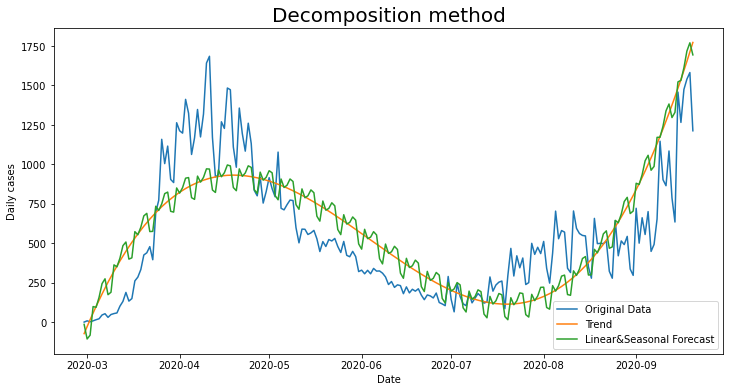

In [35]:
#plot
plt.figure(figsize =(12,6))
plt.plot(ts.index,ts, label="Original Data")
plt.plot(ts.index, f_trend, label = "Trend")
plt.plot(ts.index,additive_forecast, label= "Linear&Seasonal Forecast")
plt.title("Decomposition method", fontsize=20)
plt.xlabel("Date")
plt.ylabel("Daily cases")
plt.legend()
plt.savefig("Decomposition method")

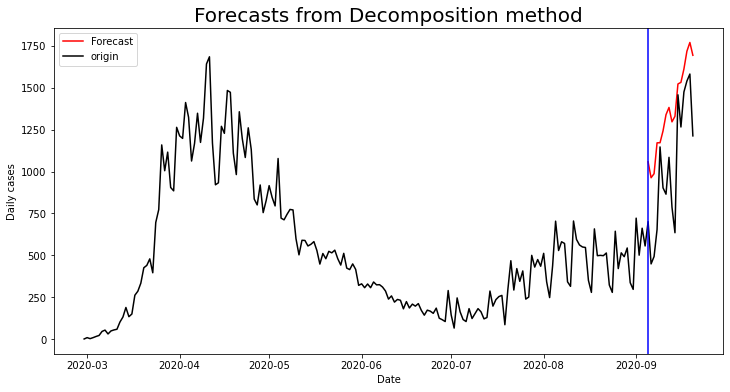

In [36]:
#step 5: Forecast the data foe last 16 days
df_fore = pd.Series(additive_forecast[-16:].reshape(16),
                    index = test_s.index)
plt.figure(figsize= (12,6))
plt.plot(df_fore[-16:],'red',label ='Forecast')
plt.plot(ts,'black',label ='origin')
plt.title('Forecasts from Decomposition method',fontsize=20)
plt.xlabel('Date')
plt.ylabel('Daily cases')
plt.legend()
plt.axvline(x =ts.index[189],color = 'blue')
plt.savefig("Forecasts from Decomposition method")

In [37]:
dec_mse = mse(test_s.values.reshape(-1,1),additive_forecast[-16:])
print("dec_mse: {0:.4f}".format(dec_mse))

dec_mse: 154197.0327


In [38]:
# Split the train, test set
train_s = train[: -15]
test_s = train[-15:]

In [39]:
# Define the mse
def mse(y_pred, y_true):
    return np.mean(np.power(y_pred - y_true,2))

# 2. Exponential smoothing

## 2.1 Trend Corrected Exponential smoothing

In [40]:
def TCES(y, alpha, beta):
    # Initialize l0, b0
    # Create lists to store values of level and trend at all time points
    l = [y[0]]
    b = [y[1] - y[0]]
    
    # Create a new variable Y to store forecast values
    Y = y.tolist()
    h = 15
    
    # Empty list to store the smoothed values
    holts_linear = []
    for i in range(len(y) + h):
        if i == len(Y):
            Y.append(l[-1] + b[-1])
        l.append(alpha * Y[i] + (1 - alpha) * (l[i] + b[i])) # Calculate level lt
        b.append(beta * (l[i+1] - l[i]) + (1 - beta) * b[i]) # Calculate trend bt
        holts_linear.append(l[i]+b[i])  # Append it to the list
    return holts_linear

In [41]:
# Initialize alpha, beta
alpha = np.arange(0.01,1,0.01)
beta = np.arange(0.01,1,0.01)

# Create lists to store values of alpha, beta and mse at all time points
alpha_beta_list = []
mse_list = []

for a in alpha:
    for b in beta:
        alpha_beta_list.append(str(a) + " " + str(b))
        pred = TCES(train_s, a, b)[:-15]
        mse_list.append(mse(train_s, pred))

In [42]:
# Find the optimal alpha and beta
alpha_beta_list[np.argmin(mse_list)]

'0.33 0.14'

In [43]:
pred = TCES(train_s, 0.33, 0.14)[-15:]
fc = pd.Series(pred, index = test_s.index)

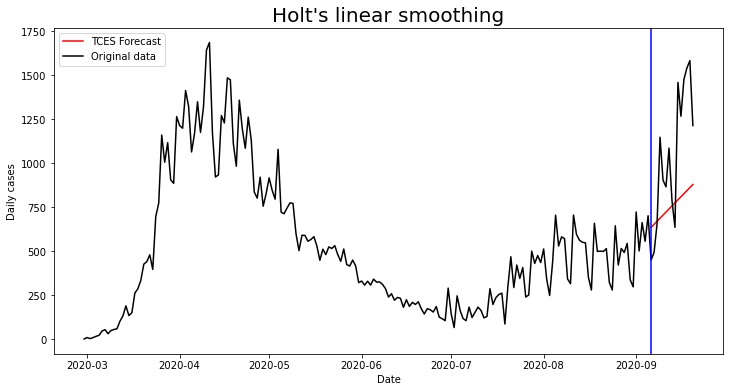

In [44]:
# Ploting the original and forecast results
plt.figure(figsize=(12,6))
plt.plot(fc[-15:], 'red', label = "TCES Forecast")
plt.plot(train, 'black', label="Original data")
plt.xlabel('Date')
plt.ylabel('Daily cases')
plt.title("Holt's linear smoothing",fontsize=20)
plt.legend()
plt.axvline(x = train.index[190],color = 'blue')
plt.savefig("Holt's linear smoothing")

In [45]:
# Test error
TCES_mse = mse(pred, test_s)
print("TCES_mse: {0:.4f}".format(TCES_mse))

TCES_mse: 177454.8796


## 2.2 Holt Winter Seasonal

In [46]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [47]:
# Holt-Winters additive smoothing
fit_add = ExponentialSmoothing(train_s, seasonal_periods=7, trend='add', seasonal='add').fit() 

# Holt-Winters multiplicative smoothing
fit_mul = ExponentialSmoothing(train_s, seasonal_periods=7, trend='add', seasonal='mul').fit()

/Users/jsh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/jsh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [48]:
fit_add.params

{'smoothing_level': 0.2821642861130214,
 'smoothing_slope': 0.17243342444916301,
 'smoothing_seasonal': 0.3566538572362468,
 'damping_slope': nan,
 'initial_level': 551.8724028838352,
 'initial_slope': 5.715865670281457,
 'initial_seasons': array([-550.87250661, -603.77683243, -601.57857092, -533.5811173 ,
        -542.47853155, -516.68403963, -518.84708312]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [49]:
# symbol r $ and \ in the results variable are the latex symbols for visualization in notebook
results = pd.DataFrame(index=[r"$\alpha$",\
                              r"$\beta$",\
                              r"$\phi$",\
                              r"$\gamma$",\
                              r"$l_0$",\
                              "$b_0$",\
                              "SSE"])
# ExponentialSmoothing() object has following attributes
params = ['smoothing_level', \
          'smoothing_slope', \
          'damping_slope', \
          'smoothing_seasonal', \
          'initial_level', \
          'initial_slope']

# check out the performance of additive and multiplicative
results["Additive"]       = [fit_add.params[p] for p in params] + [fit_add.sse]
results["Multiplicative"] = [fit_mul.params[p] for p in params] + [fit_mul.sse]
results

,Additive,Multiplicative
$\alpha$,2.821643e-01,3.663670e-01
$\beta$,1.724334e-01,1.510080e-01
$\phi$,NaN,NaN
$\gamma$,3.566539e-01,1.324844e-01
$l_0$,5.518724e+02,5.657497e+02
$b_0$,5.715866e+00,7.672880e+00
SSE,2.499739e+06,1.876416e+06


## Additive

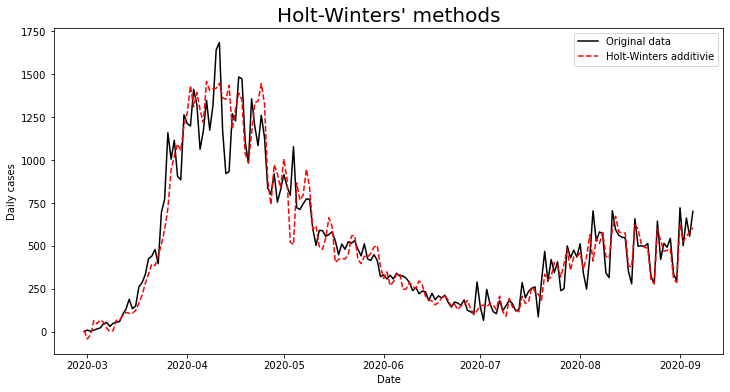

In [50]:
# Obtain fitted values from the fittedvalues attribute
smooth_add = fit_add.fittedvalues

# Plot the original and smoothing results
plt.figure(figsize=(12,6))
plt.plot(train_s, 'black', label = 'Original data')
plt.plot(smooth_add, 'r--',label = 'Holt-Winters additivie')
plt.xlabel("Date")
plt.ylabel("Daily cases")
plt.title("Holt-Winters' methods",fontsize=20)
plt.legend()
plt.savefig("Holt-Winters' methods add")

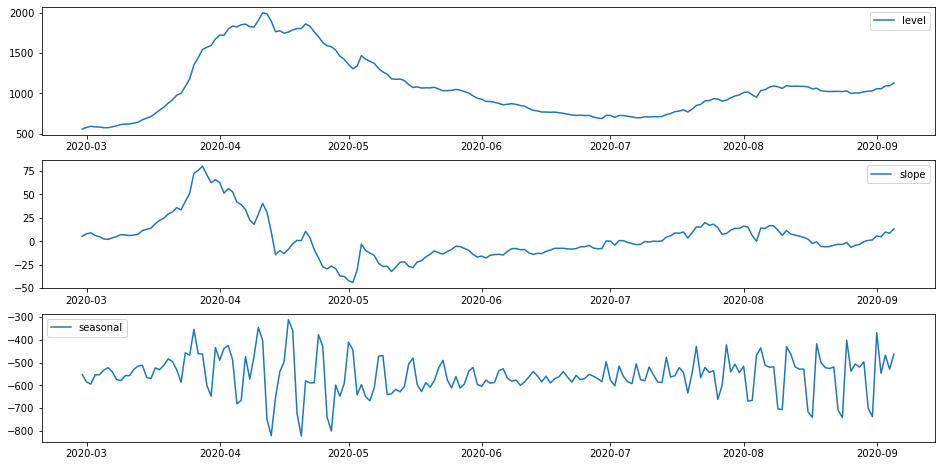

In [51]:
# plot the level, splot, seasonal
fig, ax = plt.subplots(3, 1, figsize=(16,8))
ax[0].plot(fit_add.level)
ax[1].plot(fit_add.slope)
ax[2].plot(fit_add.season)
ax[0].legend(['level'])
ax[1].legend(['slope'])
ax[2].legend(['seasonal'])
plt.savefig("smoothing_add")

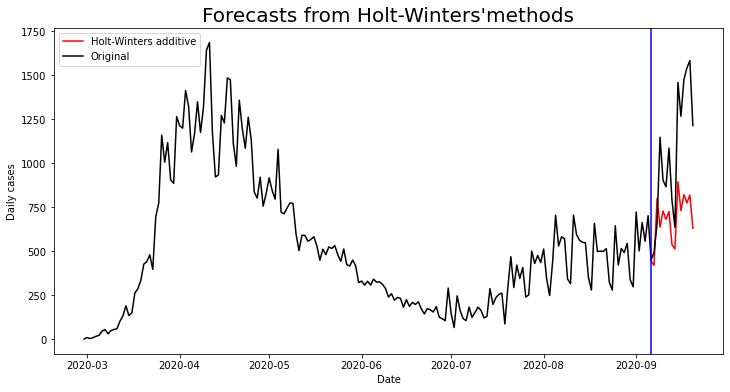

In [52]:
# Forecast 15 data points after the train set 
y_forecast_add = fit_add.forecast(15)

# Plot the original and forecast of the last 15 data points
plt.figure(figsize=(12,6))
plt.plot(y_forecast_add, 'red', label = 'Holt-Winters additive')
plt.plot(train, 'black', label = 'Original')
plt.xlabel("Date")
plt.ylabel("Daily cases")
plt.title("Forecasts from Holt-Winters'methods",fontsize=20)
plt.legend()
plt.axvline(x = train.index[190],color = 'blue')
plt.savefig("Forecasts from Holt-Winters' methods add")

In [53]:
# MSE for the last 15 days
mse_add = mse(y_forecast_add, test_s)
print("mse_add: {0:.4f}".format(mse_add))

mse_add: 207081.5015


/Users/jsh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/jsh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


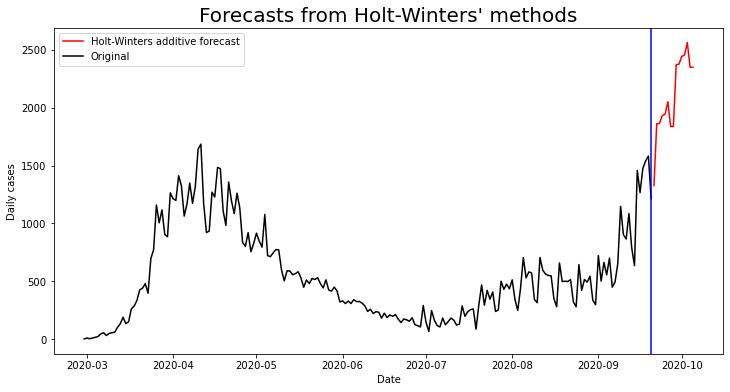

In [54]:
# Forecast for the next 15 days and plot
forecast_add = ExponentialSmoothing(train, seasonal_periods=7, trend='add', seasonal='add').fit().forecast(15)

plt.figure(figsize=(12,6))
plt.plot(forecast_add, 'red', label = 'Holt-Winters additive forecast')
plt.plot(train, 'black', label = 'Original')
plt.xlabel("Date")
plt.ylabel("Daily cases")
plt.title("Forecasts from Holt-Winters' methods",fontsize=20)
plt.legend()
plt.axvline(x = train.index[-1],color = 'blue')
plt.savefig("Forecasts from Holt-Winters' methods")

## Multiplicative

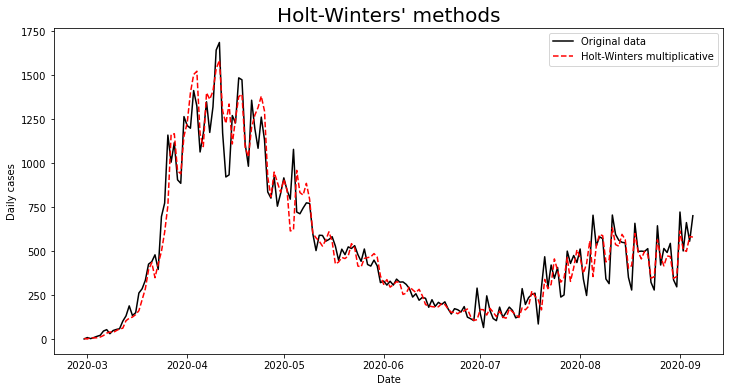

In [55]:
# Obtain fitted values from the fittedvalues attribute
smooth_mul = fit_mul.fittedvalues

# Plot the original and smoothing result
plt.figure(figsize=(12,6))
plt.plot(train_s, 'black', label = 'Original data')
plt.plot(smooth_mul, 'r--', label = 'Holt-Winters multiplicative')
plt.xlabel("Date")
plt.ylabel("Daily cases")
plt.title("Holt-Winters' methods",fontsize=20)
plt.legend()
plt.savefig("Holt-Winters' methods")

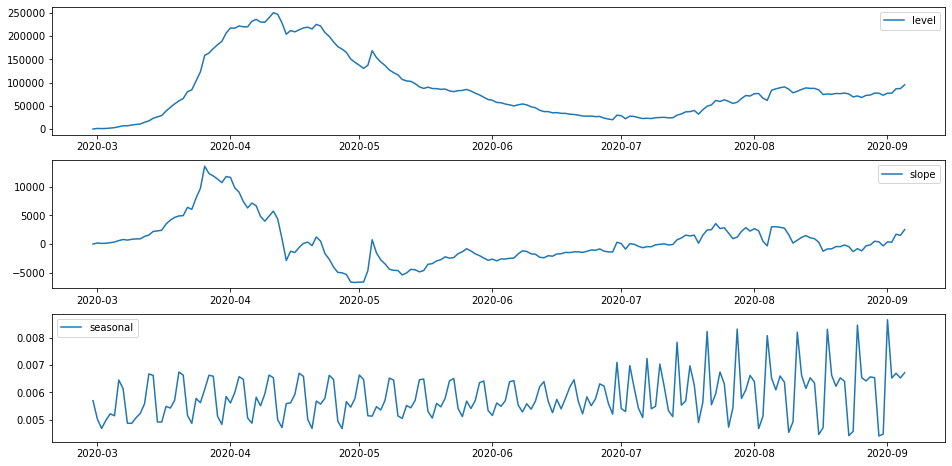

In [56]:
# plot the level, splot, seasonal
fig, ax = plt.subplots(3, 1, figsize=(16,8))
ax[0].plot(fit_mul.level)
ax[1].plot(fit_mul.slope)
ax[2].plot(fit_mul.season)
ax[0].legend(['level'])
ax[1].legend(['slope'])
ax[2].legend(['seasonal'])
plt.savefig("mul")

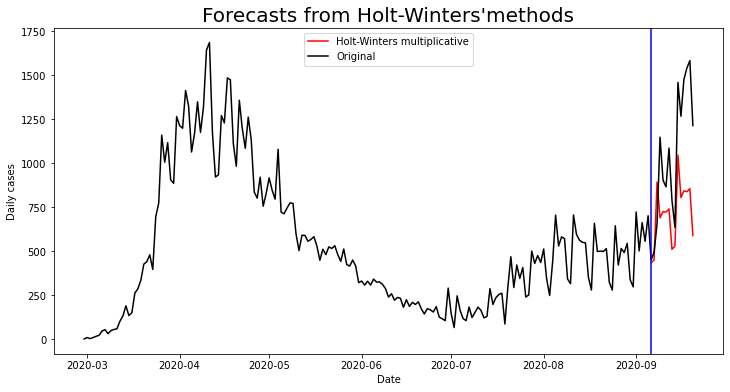

In [57]:
# Forecast 15 more data points after the train set
y_forecast_mul = fit_mul.forecast(15)

# Plot the original and forecast of the last 15 data points
plt.figure(figsize=(12,6))
plt.plot(y_forecast_mul, 'red', label = 'Holt-Winters multiplicative')
plt.plot(train, 'black', label = 'Original')
plt.xlabel("Date")
plt.ylabel("Daily cases")
plt.title("Forecasts from Holt-Winters'methods",fontsize=20)
plt.legend()
plt.axvline(x = train.index[190],color = 'blue')
plt.savefig("Forecasts from Holt-Winters'methods mul")

In [58]:
# MSE for last 15 days
mse_mul = mse(y_forecast_mul, test_s)
print("mse_mul: {0:.4f}".format(mse_mul))

mse_mul: 181712.4280


/Users/jsh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


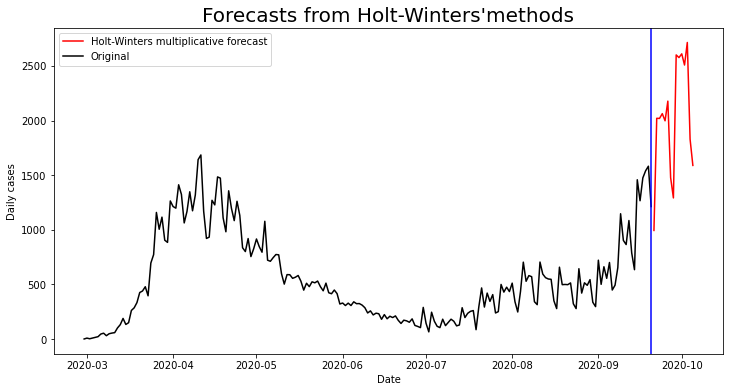

In [59]:
# Forecast for the next 15 days and plot
forecast_mul = ExponentialSmoothing(train, seasonal_periods=7, trend='add', seasonal='mul').fit().forecast(15)

plt.figure(figsize=(12,6))
plt.plot(forecast_mul, 'red', label = 'Holt-Winters multiplicative forecast')
plt.plot(train, 'black', label = 'Original')
plt.xlabel("Date")
plt.ylabel("Daily cases")
plt.title("Forecasts from Holt-Winters'methods",fontsize=20)
plt.legend()
plt.axvline(x = train.index[-1],color = 'blue')
plt.savefig("Forecasts from Holt-Winters'methods_mul")

# 3. ARIMA Model

In [60]:
df = pd.read_csv('Covid_19_train.csv')
df.head(15)

,Time,Daily_cases
0,2020-02-29,1.0
1,2020-03-01,9.0
2,2020-03-02,3.0
3,2020-03-03,9.0
4,2020-03-04,16.0
5,2020-03-05,22.0
6,2020-03-06,46.0
7,2020-03-07,54.0
8,2020-03-08,31.0
9,2020-03-09,49.0


In [61]:
df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace = True)# take the time as index
df.head()

,Daily_cases
Time,
2020-02-29,1.0
2020-03-01,9.0
2020-03-02,3.0
2020-03-03,9.0
2020-03-04,16.0


In [62]:
ts = df['Daily_cases']
ts.isnull().sum()# check is there any null value in the dataset, turns out 'no'

0

In [63]:
# train-test split
#take the data in the last 15 days as the test dataset
#why 15 days? to match the final prediction on the test dataset(15 days)

ts_trn = ts[:-15]
ts_tst = ts[-15:]

In [64]:
#differencing

ts_trn_dif = ts_trn - ts_trn.shift()
ts_trn_dif.head()
#check the result of differencing, the first row is nan, drop it

Time
2020-02-29    NaN
2020-03-01    8.0
2020-03-02   -6.0
2020-03-03    6.0
2020-03-04    7.0
Name: Daily_cases, dtype: float64

In [65]:
ts_trn_dif.dropna(inplace = True)

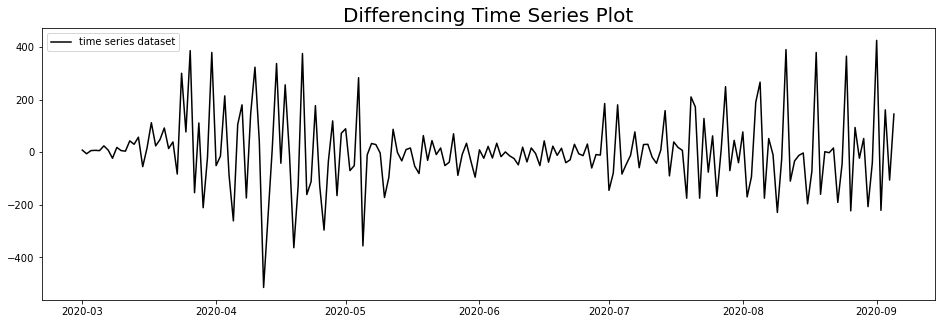

In [66]:
#plot the dataset after differencing

plt.figure(figsize = (16,5))
plt.plot(ts_trn_dif, label = 'time series dataset', color = 'black')
plt.title('Differencing Time Series Plot', fontsize = 20)
plt.legend()

plt.savefig('diff time series dataset.png')
plt.show()
#the plot shows that the data after differencing is still not stationary
#considering rolling mean

In [67]:
#compute the rolling mean, where 7 is the window size (the assumed seasonality)

rolling = ts_trn_dif.rolling(7,center = True)
roliing_mean = rolling.mean()
rolling_std = rolling.std()

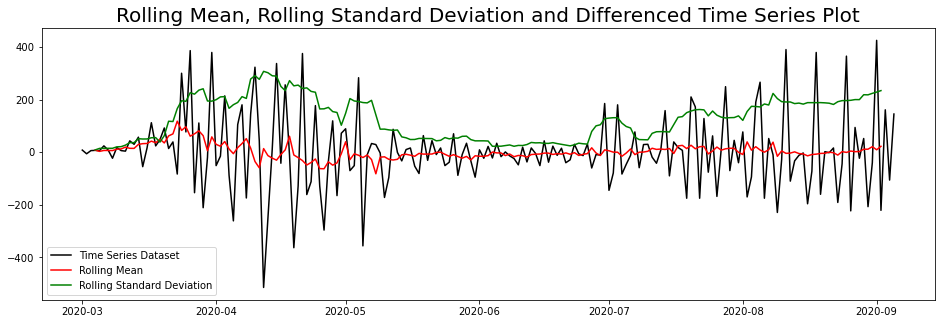

In [68]:
#plot the rolling data and time series data together

plt.figure(figsize = (16,5))
plt.plot(ts_trn_dif, label = 'Time Series Dataset', color = 'black')
plt.plot(roliing_mean, label = 'Rolling Mean', color = 'red')
plt.plot(rolling_std, label = 'Rolling Standard Deviation', color = 'green')

plt.title('Rolling Mean, Rolling Standard Deviation and Differenced Time Series Plot', fontsize = 20)
plt.legend()

plt.savefig('rolling & diff time series dataset.png')
plt.show()

#according to the plot,the first order differencing is not effective, try sencond order differencing 

In [69]:
# second order differencing

ts_trn_dif_2 = ts_trn_dif - ts_trn_dif.shift()
ts_trn_dif_2.head()

ts_trn_dif_2.dropna(inplace = True)

rolling_2 = ts_trn_dif_2.rolling(7,center = True)
roliing_mean_2 = rolling_2.mean()
rolling_std_2 = rolling_2.std()

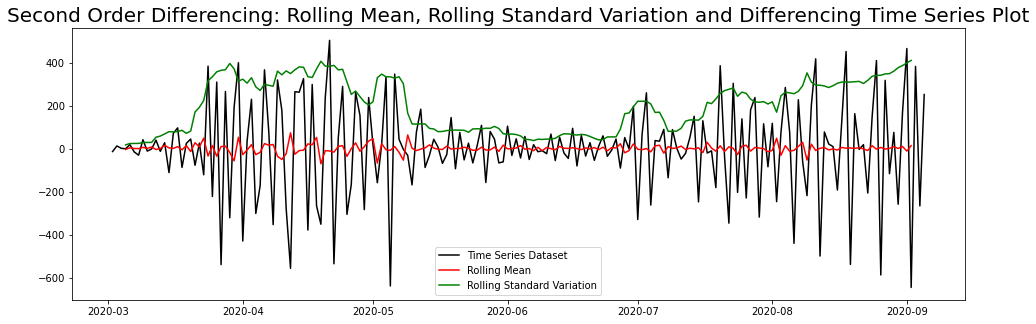

In [70]:
#plot, check the result

plt.figure(figsize = (16,5))
plt.plot(ts_trn_dif_2, label = 'Time Series Dataset', color = 'black')
plt.plot(roliing_mean_2, label = 'Rolling Mean', color = 'red')
plt.plot(rolling_std_2, label = 'Rolling Standard Variation', color = 'green')

plt.title('Second Order Differencing: Rolling Mean, Rolling Standard Variation and Differencing Time Series Plot', fontsize = 20)
plt.legend()

plt.savefig('2:rolling & diff time series dataset.png')
plt.show()
# the plot looks better (stationarility) than the first order differencing,

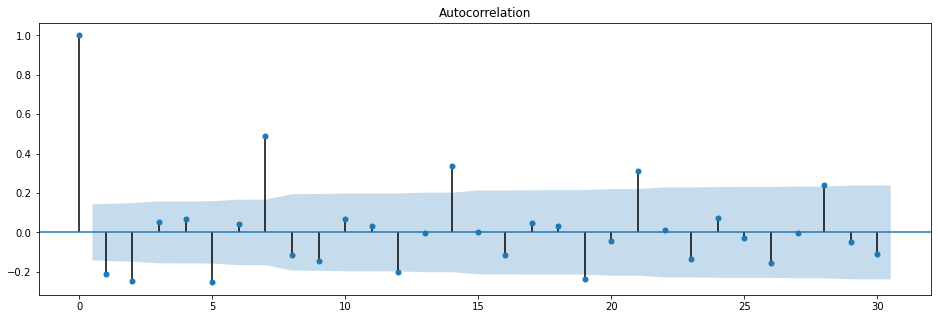

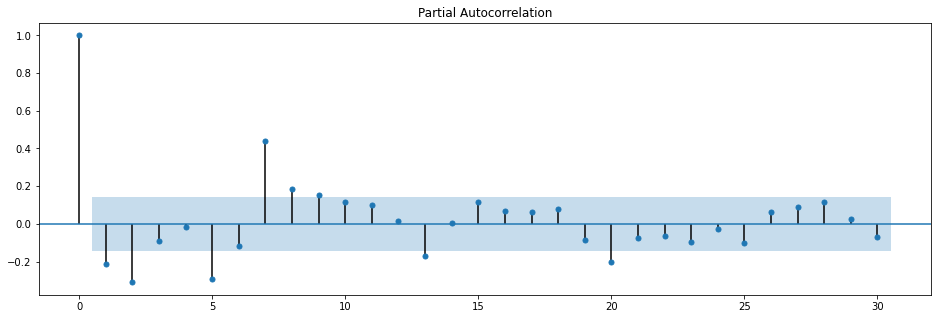

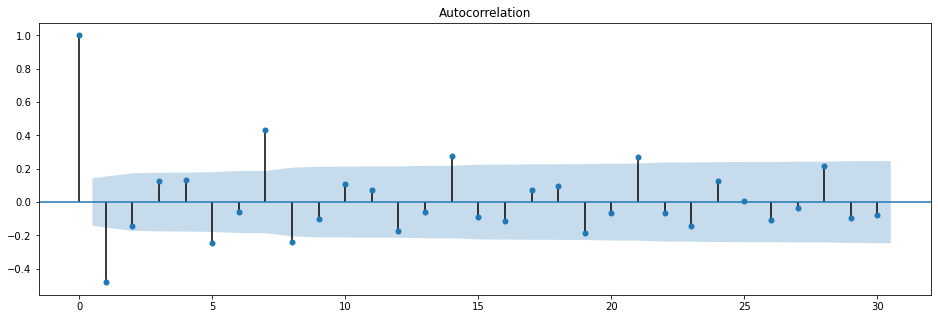

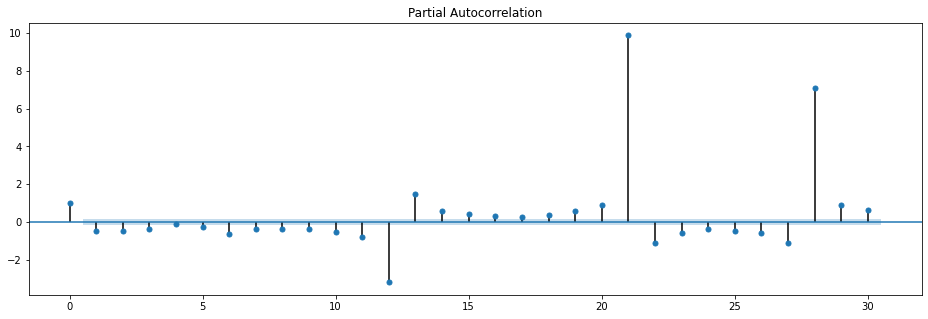

In [71]:
# ACF & PACF: choosing order for ARIMA

import statsmodels.api as smt
from pylab import rcParams
rcParams['figure.figsize']=16,5

#first order
smt.graphics.tsa.plot_acf(ts_trn_dif, lags = 30, alpha = 0.05)
plt.savefig('ACF1.png')

smt.graphics.tsa.plot_pacf(ts_trn_dif, lags = 30, alpha = 0.05)
plt.savefig('PACF1.png')

#second order
smt.graphics.tsa.plot_acf(ts_trn_dif_2, lags = 30, alpha = 0.05)
plt.savefig('ACF2.png')

smt.graphics.tsa.plot_pacf(ts_trn_dif_2, lags = 30, alpha = 0.05)
plt.savefig('PACF2.png')

#according to the feedback in the next step, only the plots of first order differencing being discussed

In [72]:
from statsmodels.tsa.arima_model import ARIMA

# use the ideal order (5,2,4) first, but the code below keeps reporting error
#did reseach on the error message, there are two possible reasons:
#1.overdifferenced; 2. the ARIMA start_params search is not very robust

#thus, chossing the order for first order differencing
p,q = 5,5
ARIMA = ARIMA(ts_trn, order = (p,1,q))#1 means the first order differencing

#fit the model and compute residuals
ARIMA_result = ARIMA.fit(disp = -1)
ARIMA_residual =pd.DataFrame(ARIMA_result.resid)

/Users/jsh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/jsh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


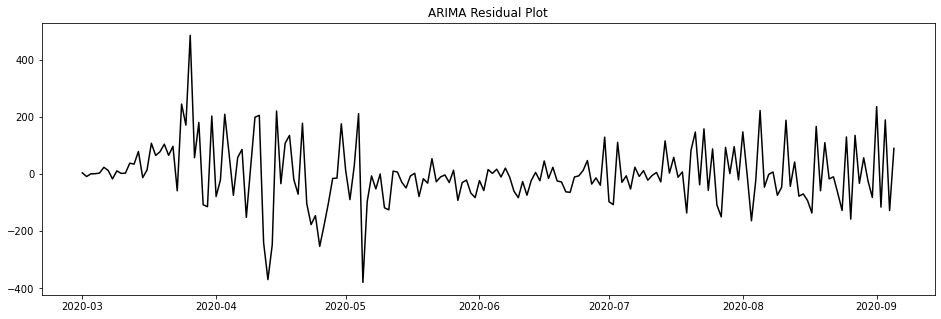

In [73]:
# plot the residual error
plt.figure(figsize = (16,5))
plt.plot(ARIMA_residual, color = 'black')
plt.title('ARIMA Residual Plot')

plt.savefig('ARIMA Residual.png')
plt.show()
#the residual plot shows no obvious patern.

In [74]:
#fitted time series

series_fitted = ARIMA_result.predict(typ = 'levels', dynamic = False)

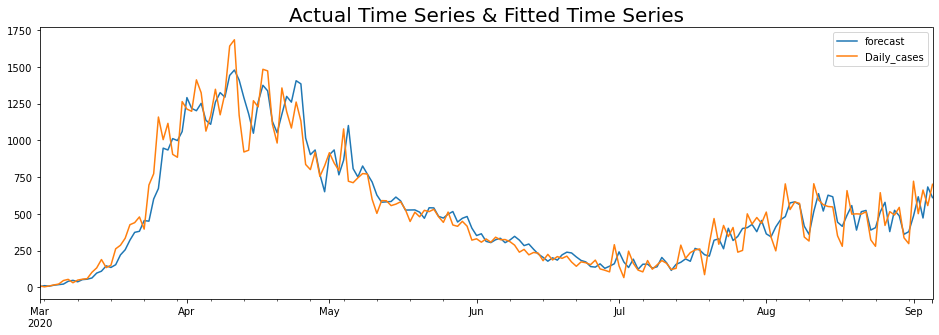

In [75]:
#plot to compare Actual data and Forecasts
ARIMA_result.plot_predict(dynamic = False)

plt.title('Actual Time Series & Fitted Time Series', fontsize = 20)
plt.savefig('Actual Data & Forecastes.png')
plt.show()

In [76]:
ARIMA_result.forecast(15) # the forecasting result consists of three arrays

(array([523.48299283, 551.91589736, 672.56688816, 657.87911537,
        590.2270912 , 684.88133131, 718.05077276, 600.04100231,
        586.79081224, 688.92686558, 663.64157263, 602.83516668,
        686.34243631, 736.64192957, 644.45266286]),
 array([106.42192344, 118.05015515, 123.31148791, 131.20634929,
        142.67565673, 154.37999917, 176.14565099, 200.66909755,
        213.44121671, 220.24258564, 228.05590667, 234.67773069,
        239.83758027, 249.33546194, 263.46754286]),
 array([[ 314.89985572,  732.06612993],
        [ 320.54184489,  783.28994983],
        [ 430.88081297,  914.25296334],
        [ 400.71939621,  915.03883452],
        [ 310.58794253,  869.86623986],
        [ 382.30209299,  987.46056962],
        [ 372.81164079, 1063.28990474],
        [ 206.7367983 ,  993.34520631],
        [ 168.45371467, 1005.12790981],
        [ 257.25932986, 1120.5944013 ],
        [ 216.66020909, 1110.62293617],
        [ 142.87526656, 1062.79506681],
        [ 216.26941684, 1156.415

In [77]:
# use the model to forecast the test dataset
predict,_,_ = ARIMA_result.forecast(15)# take the first array

#compute mse
from sklearn.metrics import mean_squared_error
ARIMA_mse = mean_squared_error(predict,ts_tst)
print("ARIMA_mse: {0:.4f}".format(ARIMA_mse))

ARIMA_mse: 268851.0051


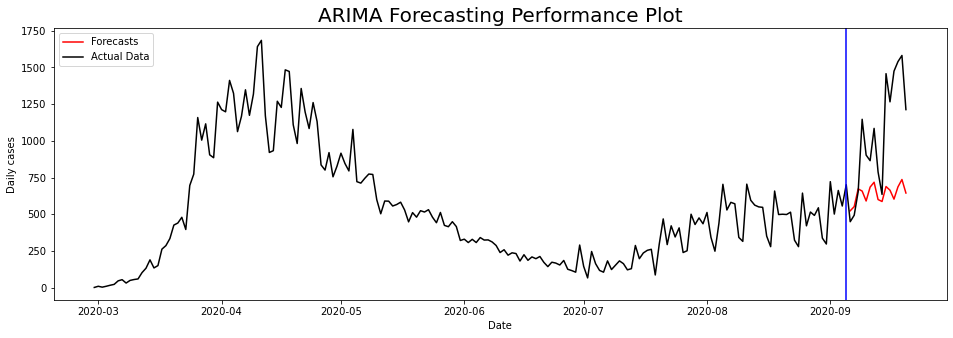

In [78]:
#plot to check the forecasting performance
ARIMA_forecastes = pd.Series(predict, index = ts_tst.index)

plt.figure(figsize = (16,5))
plt.plot(ARIMA_forecastes, label = 'Forecasts', color = 'red')
plt.plot(ts, label = 'Actual Data', color = 'black')
plt.title('ARIMA Forecasting Performance Plot', fontsize = 20)
plt.xlabel('Date')
plt.ylabel('Daily cases')
plt.legend()
plt.axvline(x = ts.index[189], color = 'blue')# put the reference line at the day 189(the last day of training dataset)

plt.savefig('actual and forecasts.png')
plt.show()

# 4. SARIMA Model

In [79]:
df=pd.read_csv('Covid_19_train.csv')
df['Time']=pd.to_datetime(df['Time'])
df.set_index('Time',inplace=True)
train=df['Daily_cases']

train_s = train[: -15]
test_s = train[-15:]

def mse(y_pred, y_true):
    return np.mean(np.power(y_pred - y_true,2))

train_s_diff=train_s-train_s.shift()
train_s_diff.dropna(inplace=True)

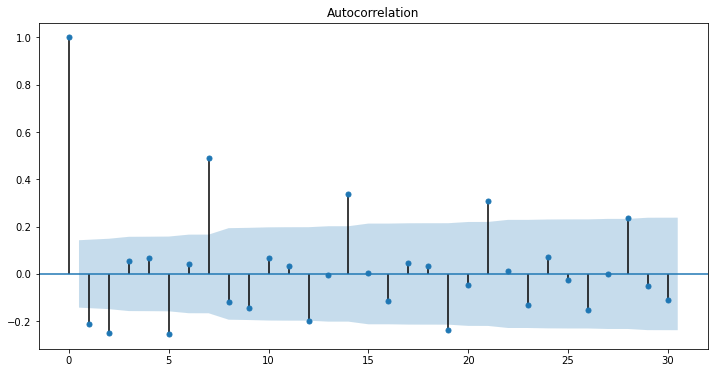

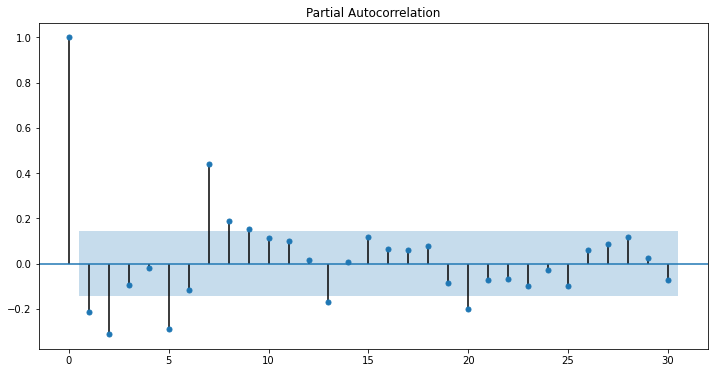

In [80]:
import statsmodels.api as smt
from pylab import rcParams
rcParams['figure.figsize']=12,6
smt.graphics.tsa.plot_acf(train_s_diff,lags=30,alpha=0.05)
smt.graphics.tsa.plot_pacf(train_s_diff,lags=30,alpha=0.05)
plt.show()

/Users/jsh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/jsh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/jsh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


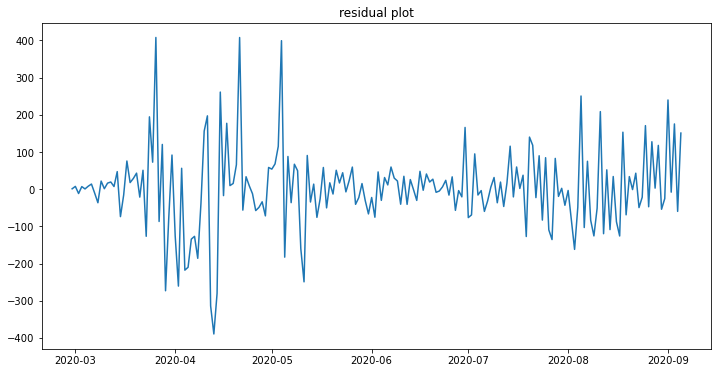

In [81]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarimax=SARIMAX(train_s,order=(4,2,4),seasonal_order=(1,0,0,7),enforce_stationarity=False,enforce_invertibility=False)
sarimax_fit=sarimax.fit(disp=-1)
residuals_sarima=pd.DataFrame(sarimax_fit.resid)
plt.figure(figsize=(12,6))
plt.plot(residuals_sarima)
plt.title('residual plot')
plt.show()

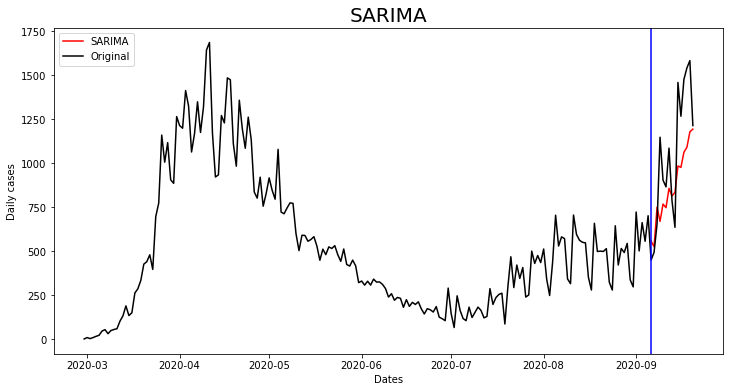

In [82]:
y_forecast_sarimax=sarimax_fit.forecast(15)
plt.figure(figsize=(12,6))
plt.plot(y_forecast_sarimax,'red',label='SARIMA')
plt.plot(train,'black',label='Original')
plt.title('SARIMA',fontsize=20)
plt.xlabel('Dates')
plt.ylabel('Daily cases')
plt.legend()
plt.axvline(x=train.index[190],color='blue')
plt.show()

In [83]:
sarima_mse=mse(y_forecast_sarimax,test_s)
print("SARIMA_mse: {0:.4f}".format(sarima_mse))

SARIMA_mse: 81521.2670


/Users/jsh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/jsh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/jsh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


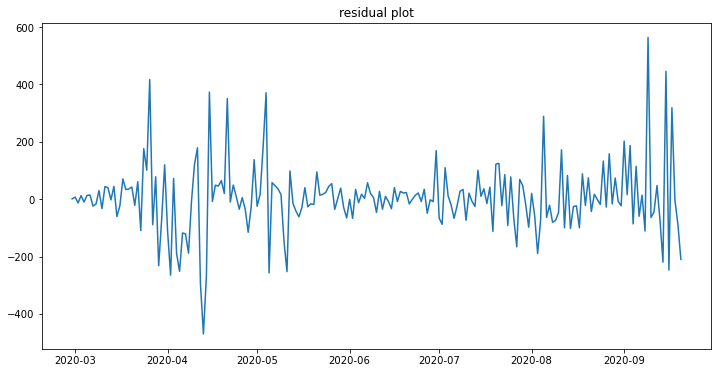

In [84]:
sarimax1=SARIMAX(train,order=(4,2,4),seasonal_order=(1,0,0,7),enforce_stationarity=False,enforce_invertibility=False)
sarimax1_fit=sarimax1.fit(disp=-1)
residuals_sarima1=pd.DataFrame(sarimax1_fit.resid)
plt.figure(figsize=(12,6))
plt.plot(residuals_sarima1)
plt.title('residual plot')
plt.show()

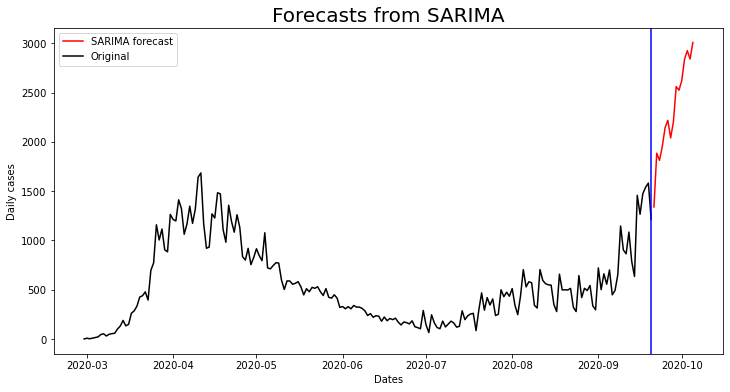

In [85]:
sarimax_forecast=sarimax1_fit.forecast(15)
plt.figure(figsize=(12,6))
plt.plot(sarimax_forecast,'red',label='SARIMA forecast')
plt.plot(train,'black',label='Original')
plt.title('Forecasts from SARIMA',fontsize=20)
plt.xlabel('Dates')
plt.ylabel('Daily cases')
plt.legend()
plt.axvline(x=train.index[-1],color='blue')
plt.show()

# Final Forecast

In [86]:
columns=['RMSE']
index=['DEC','TCES','HW_add','HW_mul','ARIMA','SARIMA']
MSE=np.array([dec_mse,TCES_mse,mse_add,mse_mul,ARIMA_mse,sarima_mse])
RMSE=np.sqrt(MSE)
Summary=pd.DataFrame(RMSE,index=index,columns=columns)
Summary.round(4)

,RMSE
DEC,392.6793
TCES,421.2539
HW_add,455.0621
HW_mul,426.2774
ARIMA,518.5084
SARIMA,285.5193


In [87]:
sarimax_forecast

2020-09-21    1339.887033
2020-09-22    1885.173739
2020-09-23    1812.994407
2020-09-24    1953.080233
2020-09-25    2142.947240
2020-09-26    2218.382502
2020-09-27    2039.912880
2020-09-28    2202.284435
2020-09-29    2560.835923
2020-09-30    2523.911854
2020-10-01    2619.918444
2020-10-02    2838.643332
2020-10-03    2925.558464
2020-10-04    2840.566843
2020-10-05    3008.169153
Freq: D, dtype: float64

In [88]:
covid_19_test=pd.read_csv('Covid_19_test.csv')

test_error=mse(sarimax_forecast.values, covid_19_test['Daily_cases'].values)

print("test error: {0:.4f}".format(test_error))

FileNotFoundError: [Errno 2] File Covid_19_test.csv does not exist: 'Covid_19_test.csv'